Estamos tratando con problemas NP (Non-deterministic search, polinomial check), en los que una búsqueda exhaustiva es simplemente imposible.

El problema TSP (Travelling Sales Person) trata de encontrar en recorrido más corto que pase por todas las ciudades de un conjunto dado.


Refs:

- GA Tutorial [here](http://www.obitko.com/tutorials/genetic-algorithms/index.php)
- Compendium of NP Optimization Problems [here](http://www.csc.kth.se/~viggo/problemlist/)    
    

[[ 2 88]
 [87 84]
 [84  6]
 [99 37]
 [60 87]
 [ 8 83]
 [43 33]
 [45 66]
 [28 94]
 [ 3 56]
 [14 92]
 [88 10]
 [33 12]
 [33 85]
 [69 60]
 [67 58]
 [80 19]
 [81 30]
 [69 21]
 [78 35]]


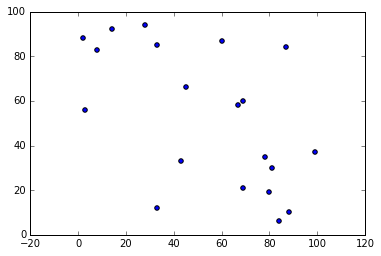

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
w_size = 100
n_cities = 20
cities = (np.random.random((n_cities,2))*w_size).astype(int)
cities = np.array([[ 2,88],[87,84],[84,6],[99,37], [60, 87], [ 8, 83], [43, 33], [45, 66], [28, 94], [ 3, 56], [14, 92], [88, 10], [33, 12], [33, 85], [69, 60], [67, 58], [80, 19], [81, 30], [69, 21], [78, 35]])

plt.scatter(cities[:,0], cities[:,1])
print cities

In [21]:
def TSP_plot_solution(cities, solution):
    plt.scatter(cities[:,0], cities[:,1])
    plt.plot(cities[solution,0].tolist()+[cities[solution[0],0]], cities[solution,1].tolist()+[cities[solution[0],1]])
    plt.scatter(cities[solution[0],0], cities[solution[0],1], marker="x", s=60, c="red", lw="5")
    plt.title("cost %.3f"%(TSP_cost(cities, solution)))
    
def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

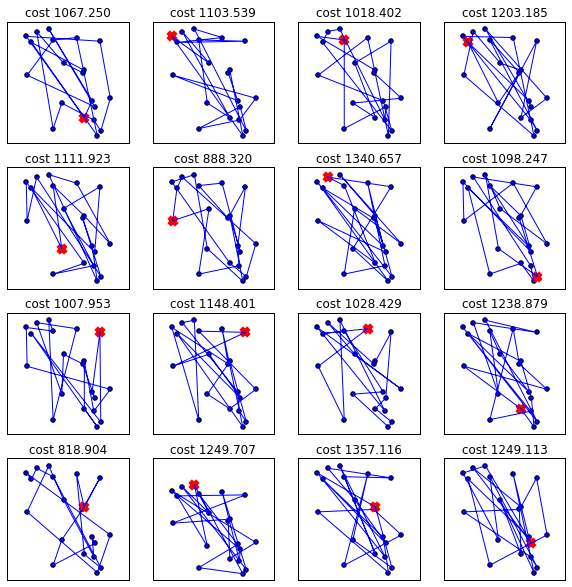

In [22]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    one_solution = np.random.permutation(n_cities)
    TSP_plot_solution(cities, one_solution)
    ax.set_xticks([])
    ax.set_yticks([])

In [30]:
def TSP_mutate(solution, mutation_prob):
    mutated_solution = np.copy(solution)
    for i in range(len(solution)):
        if np.random.random()<mutation_prob:
            j = i+1 if i!=len(solution)-1 else 0
            tmp = mutated_solution[i]
            mutated_solution[i] = mutated_solution[j]
            mutated_solution[j] = tmp
    return mutated_solution


def TSP_cross_over(solution1, solution2):
    l = len(solution1)
    cstart = np.random.randint(l)
    cend   = np.random.randint(l-cstart)+cstart+1
    
    r = np.zeros(l)
    s1part = solution1[cstart:cend]
    r[cstart:cend] = s1part
    c = 0
    for i in range(l):
        c = cend if c==cstart else c
        if not solution2[i] in s1part:
            r[c]=solution2[i]
            c += 1
            
    return r

def TSP_initialize_population(n_individuals, n_cities):
    r = []
    for i in xrange(n_individuals):
        r.append(np.random.permutation(n_cities))
    return np.array(r)

def TSP_plot_GA_result(best, bests, means, stds):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    TSP_plot_solution(cities, best)

In [31]:
%%writefile code/ga.py
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()
    

def run_ga(pop_size, init_population_function, 
           mutation_function, crossover_function, cost_function, 
           crossover_prob, mutation_prob, n_iters):

    pop = init_population_function(pop_size)
    n_xover_indivs = int(pop_size * crossover_prob)

    means = []
    stds  = []
    best_costs = []
    best = None

    for i in xrange(n_iters):

        #if i%(n_iters/10)==0:
        # print i
        
        # do cross over
        offsprings = []
        idx_xover_indivs = np.random.permutation(len(pop))[n_xover_indivs:]
        for idx in idx_xover_indivs:
            idx_counterpart = np.random.randint(len(pop))
            i1 = pop[idx]
            i2 = pop[idx_counterpart]
            offs = crossover_function(i1,i2)
            offsprings.append(offs)
        offsprings = np.array(offsprings)

        pop = np.vstack((pop, offsprings)).astype(int)

        # mutate population
        for j in xrange(len(pop)):
            pop[j] = mutation_function(pop[j], mutation_prob)

        # select best to maintain pop_size fixed
        costs = np.array([cost_function(j) for j in pop])
        top_idxs  = np.argsort(costs)[:pop_size]
        pop = pop[top_idxs]

        costs = costs[top_idxs]

        means.append(np.mean(costs))
        stds.append(np.std(costs))
        best_costs.append(np.min(costs))
        
        if best is None or np.min(costs) < cost_function(best):
             best = pop[np.argmin(costs)]

    means      = np.array(means)
    stds       = np.array(stds)
    best_costs = np.array(best_costs)
    
    
    return best, best_costs, means, stds


Overwriting code/ga.py


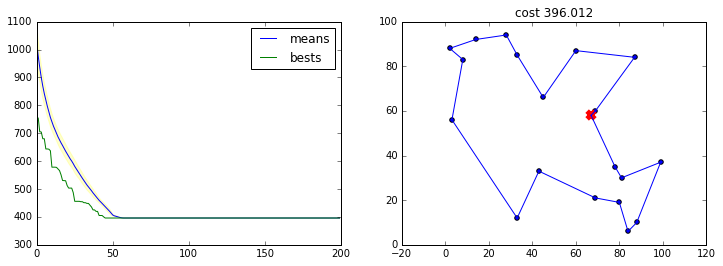

In [42]:
%run code/ga.py

r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.001,
               mutation_prob            = 0.001, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy pequeña

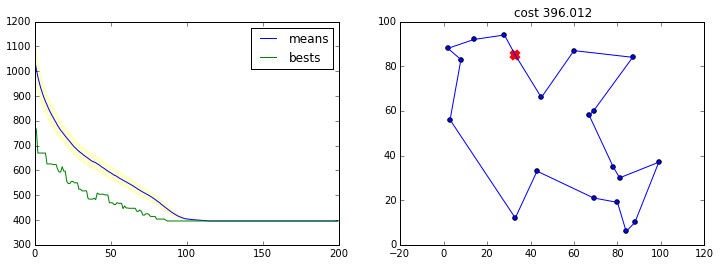

In [15]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.01, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de cruce muy pequeña

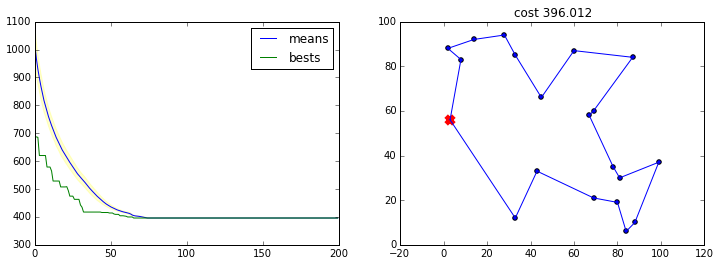

In [16]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities),  
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.01,
               mutation_prob            = 0.001, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)

Con una probabilidad de mutación muy alta

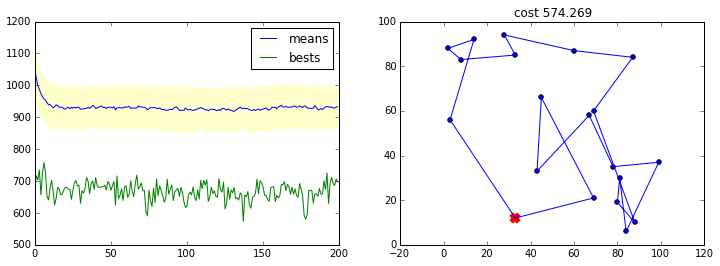

In [17]:
r =  run_ga(pop_size=1000, 
               init_population_function = lambda x: TSP_initialize_population(x, n_cities), 
               mutation_function        = TSP_mutate, 
               crossover_function       = TSP_cross_over,
               cost_function            = lambda x: TSP_cost(cities, x), 
               crossover_prob           = 0.5,
               mutation_prob            = 0.9, 
               n_iters                  = 200)

best, best_costs, means, stds = r
TSP_plot_GA_result(best, best_costs, means, stds)